# Home Loan Approval

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
pd.options.display.float_format = "{:.0f}".format

## Importing and preparing data for analysis

Let's import the data, and have a quick look at columns, values and types!

In [2]:
df = pd.read_csv("loan_sanction_train.csv")

In [3]:
df.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0,NaN,360,1,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508,128,360,1,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0,66,360,1,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358,120,360,1,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0,141,360,1,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196,267,360,1,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516,95,360,1,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504,158,360,0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526,168,360,1,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968,349,360,1,Semiurban,N


The columns' name meaning from the official documentation:
- Loan_id: Unique Loan ID
- Gender: Female / Male
- Married: Applicant married (Y / N)
- Dependents: Number of dependents
- Education: Applicant Education (Graduate / Under Graduate)
- Self_Employed: Self-employed (Y / N)
- ApplicantIncome: Applicant's income
- CoapplicantIncome: Co-applicant income
- LoanAmount: Loan amount in thousands
- Loan_Amount_Term: Term of the loan in months
- Credit_History: Credit history meets guidelines (1 - Yes, 2 - No)
- Property_Area: Property area is Urban / Semi Urban / Rural
- Loan_Status: Loan is approved (Y / N)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


Let's check the Dependents column to see if it is possible to convert it to integer type! 

In [5]:
df["Dependents"].value_counts()

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64

For the EDA, "3+" can remain, but for the machine learning model, we'll change it to 3.

It is strange to have credit history as integer, let's change to Yes and No values.

In [6]:
df["Credit_History"] = df["Credit_History"].apply(lambda x: "Yes" if x == 1 else "No")

Now let's see, if there are any duplicates

In [7]:
df.duplicated().any()

False

Great. Let's check the null values!

In [8]:
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

Not good. Can we fill the missing vales? Unfortunately we may alter significantly our statistical analysis if we try to guess the values in this case. It is better to drop them.

In [9]:
df.dropna(inplace = True)

Let's create a total income column, and drop the applicant and coapplicant income column. They are not needed separately for loan approval analysis.

In [10]:
df["Total Income"] = df["ApplicantIncome"] + df["CoapplicantIncome"]
df = df.drop(["ApplicantIncome", "CoapplicantIncome"], axis = 1)

And finally, the cleaned dataframe:

In [11]:
df.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total Income
1,LP001003,Male,Yes,1,Graduate,No,128,360,Yes,Rural,N,6091
2,LP001005,Male,Yes,0,Graduate,Yes,66,360,Yes,Urban,Y,3000
3,LP001006,Male,Yes,0,Not Graduate,No,120,360,Yes,Urban,Y,4941
4,LP001008,Male,No,0,Graduate,No,141,360,Yes,Urban,Y,6000
5,LP001011,Male,Yes,2,Graduate,Yes,267,360,Yes,Urban,Y,9613
6,LP001013,Male,Yes,0,Not Graduate,No,95,360,Yes,Urban,Y,3849
7,LP001014,Male,Yes,3+,Graduate,No,158,360,No,Semiurban,N,5540
8,LP001018,Male,Yes,2,Graduate,No,168,360,Yes,Urban,Y,5532
9,LP001020,Male,Yes,1,Graduate,No,349,360,Yes,Semiurban,N,23809
10,LP001024,Male,Yes,2,Graduate,No,70,360,Yes,Urban,Y,3900


## Exploratory Data Analyis

Let's take a look at some statistical values!

In [12]:
df.describe()

,LoanAmount,Loan_Amount_Term,Total Income
count,523,523,523
mean,145,342,6921
std,83,66,5877
min,9,12,1442
25%,100,360,4128
50%,128,360,5428
75%,171,360,7622
max,650,480,81000


Now, we sure have outliers in the data. Let's remove them from the first 3 columns:

In [13]:
def remove_outliers(column):    
    q3, q1 = np.percentile(df[column], [75, 25])
    IQR = q3 - q1
    upper_bound = q3 + 1.5 * IQR
    lower_bound = q1 - 1.5 * IQR
    return df.loc[(df[column] < upper_bound) & (df[column] > lower_bound)]

In [14]:
df = remove_outliers('Total Income')
df = remove_outliers("LoanAmount")

In [15]:
df.describe()

,LoanAmount,Loan_Amount_Term,Total Income
count,456,456,456
mean,125,341,5468
std,44,68,2147
min,17,12,1442
25%,99,360,3894
50%,122,360,5000
75%,153,360,6500
max,246,480,12543


For the upcoming parts, we'll answer some questions regarding the relationship between loan approval and some other cathegorical variables. For that, we'll first create a histogram for visual comparison and do a chi-square test for statistical analysis. Let's make a function for this repetative work:

In [16]:
def are_they_related(var1, var2, significance_level):
    order = sorted(list(set(df[var1])), reverse=False)
    plt.figure(figsize = (4,4))
    sns.histplot(x = df[var2], hue = df[var1], hue_order = order, multiple = "stack")
    plt.show()
    print(f"Null hypohtesis (H0): {var1} is indenpendent of the {var2}")
    print(f"Alternative hypothesis (H1): {var1} is not independent of the {var2}")

    alpha = significance_level

    # Create a contingency table with gender and loan approval counts
    cont_table = pd.crosstab(df[var1], df[var2])
    # use chi2_contingency function from stats module to determine p value
    stat, p, dof, expected = stats.chi2_contingency(cont_table)
    print(f"Result of using a chi-square test with a significance level of {significance_level}:")
    print()
    if p <= alpha:
        print(f'Reject H0 - {var1} is dependent of the {var2}')
    else:
        print(f'Retain H0 - {var1} is not significantly dependent of the {var2}')

### Is there any significant relationship between gender and loan approval?

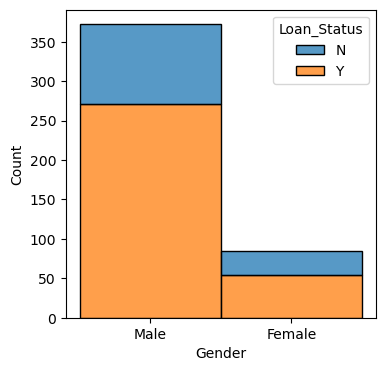

Null hypohtesis (H0): Loan_Status is indenpendent of the Gender
Alternative hypothesis (H1): Loan_Status is not independent of the Gender
Result of using a chi-square test with a significance level of 0.05:

Retain H0 - Loan_Status is not significantly dependent of the Gender


In [17]:
are_they_related("Loan_Status", "Gender", 0.05)

### Is there any significant relationship between education and loan approval?

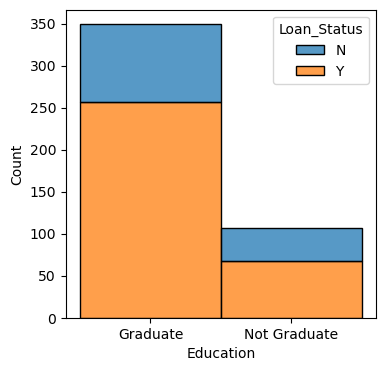

Null hypohtesis (H0): Loan_Status is indenpendent of the Education
Alternative hypothesis (H1): Loan_Status is not independent of the Education
Result of using a chi-square test with a significance level of 0.05:

Retain H0 - Loan_Status is not significantly dependent of the Education


In [18]:
are_they_related("Loan_Status", "Education", 0.05)

### Is there any significant relationship between being married and loan approval?

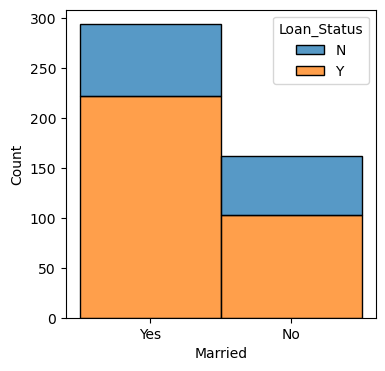

Null hypohtesis (H0): Loan_Status is indenpendent of the Married
Alternative hypothesis (H1): Loan_Status is not independent of the Married
Result of using a chi-square test with a significance level of 0.05:

Reject H0 - Loan_Status is dependent of the Married


In [19]:
are_they_related("Loan_Status", "Married", 0.05)

### Is there any significant relationship between number of dependents and loan approval?

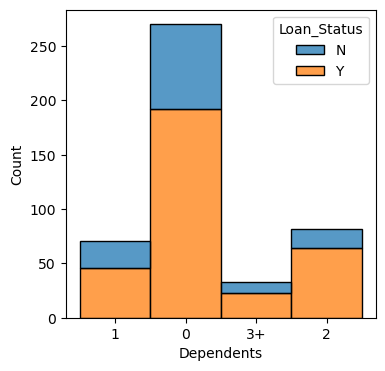

Null hypohtesis (H0): Loan_Status is indenpendent of the Dependents
Alternative hypothesis (H1): Loan_Status is not independent of the Dependents
Result of using a chi-square test with a significance level of 0.05:

Retain H0 - Loan_Status is not significantly dependent of the Dependents


In [20]:
are_they_related("Loan_Status", "Dependents", 0.05)

### Is there any significant relationship between being self employed and loan approval?

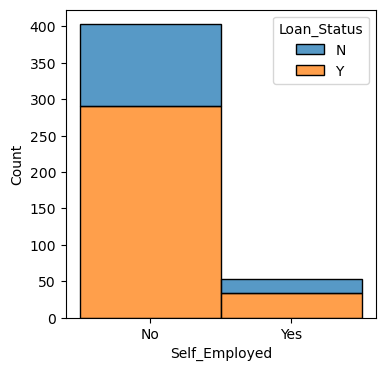

Null hypohtesis (H0): Loan_Status is indenpendent of the Self_Employed
Alternative hypothesis (H1): Loan_Status is not independent of the Self_Employed
Result of using a chi-square test with a significance level of 0.05:

Retain H0 - Loan_Status is not significantly dependent of the Self_Employed


In [21]:
are_they_related("Loan_Status", "Self_Employed", 0.05)

### Is there any significant relationship between having credit history according to guidelines and loan approval?

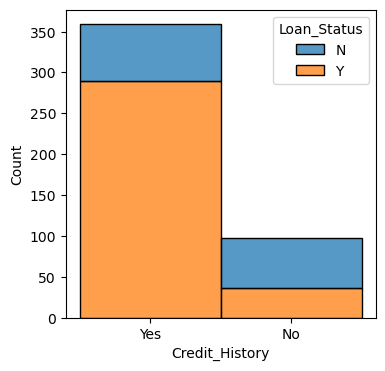

Null hypohtesis (H0): Loan_Status is indenpendent of the Credit_History
Alternative hypothesis (H1): Loan_Status is not independent of the Credit_History
Result of using a chi-square test with a significance level of 0.05:

Reject H0 - Loan_Status is dependent of the Credit_History


In [22]:
are_they_related("Loan_Status", "Credit_History", 0.05)

### Is there any significant relationship between property area and loan approval?

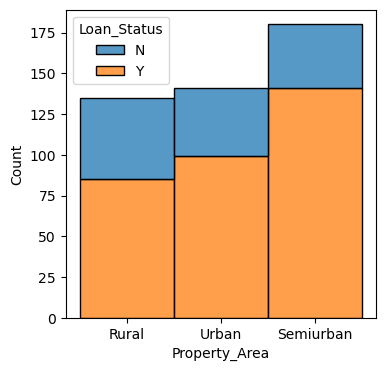

Null hypohtesis (H0): Loan_Status is indenpendent of the Property_Area
Alternative hypothesis (H1): Loan_Status is not independent of the Property_Area
Result of using a chi-square test with a significance level of 0.05:

Reject H0 - Loan_Status is dependent of the Property_Area


In [23]:
are_they_related("Loan_Status", "Property_Area", 0.05)

For the upcoming parts, we'll answer some questions regarding the relationship between loan approval and some other continous variables. For that, we'll first create a areaplot for visual comparison and do a two-sample t test for statistical analysis. Let's make a function for this repetative work:

In [24]:
def have_they_the_same_mean(ind_var, dep_var, significance_level):
    yes = df.loc[df[ind_var] == "Y"][dep_var]
    no = df.loc[df[ind_var] == "N"][dep_var]
    plt.figure(figsize = (8,4))
    sns.violinplot(x = df[dep_var], y = df[ind_var], dodge = True)
    plt.show()
    print(f"Null hypohtesis (H0): The mean of {dep_var} is the same for approved and not approved {ind_var}")
    print(f"Alternative hypothesis (H1): The mean of {dep_var} is different for approved and not approved {ind_var}")

    alpha = significance_level

    # use two-sample t test and its function from stats module to determine p value
    stat, p = stats.ttest_ind(yes, no, equal_var = False, trim = 0.02)
    print(f"Result of using a two_sample t test with a significance level of {significance_level}:")
    print()
    if p <= alpha:
        print(f'Reject H0 - The mean of {dep_var} is different for approved and not approved {ind_var}')
    else:
        print(f'Retain H0 - The mean of {dep_var} is not significantly different for approved and not approved {ind_var}')

### Is there any significant relationship total income and loan approval?

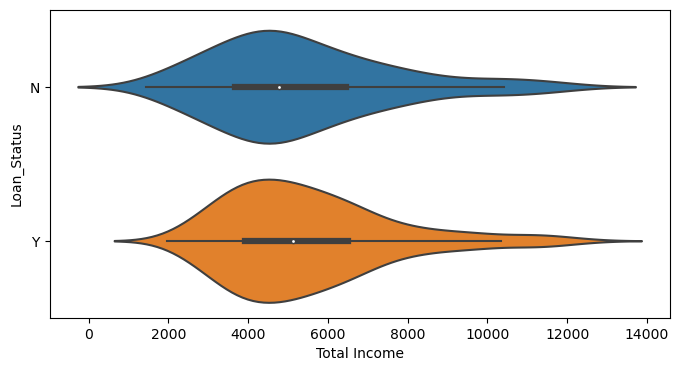

Null hypohtesis (H0): The mean of Total Income is the same for approved and not approved Loan_Status
Alternative hypothesis (H1): The mean of Total Income is different for approved and not approved Loan_Status
Result of using a two_sample t test with a significance level of 0.05:

Retain H0 - The mean of Total Income is not significantly different for approved and not approved Loan_Status


In [25]:
have_they_the_same_mean("Loan_Status", "Total Income", 0.05)

### Is there any significant relationship loan amount and loan approval?

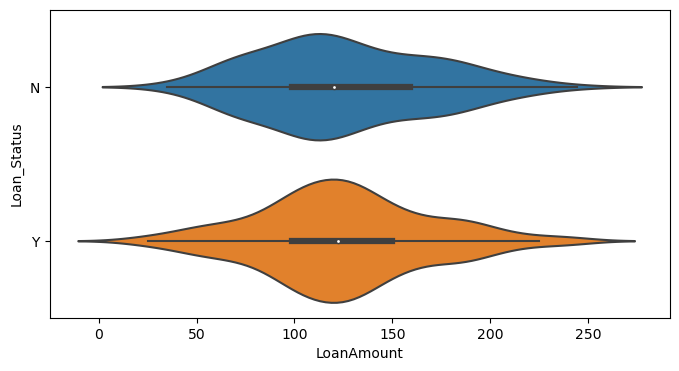

Null hypohtesis (H0): The mean of LoanAmount is the same for approved and not approved Loan_Status
Alternative hypothesis (H1): The mean of LoanAmount is different for approved and not approved Loan_Status
Result of using a two_sample t test with a significance level of 0.05:

Retain H0 - The mean of LoanAmount is not significantly different for approved and not approved Loan_Status


In [26]:
have_they_the_same_mean("Loan_Status", "LoanAmount", 0.05)

### Is there any significant relationship loan amount term and loan approval?

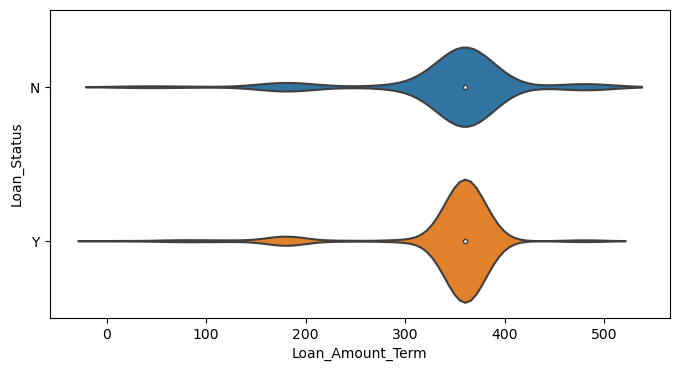

Null hypohtesis (H0): The mean of Loan_Amount_Term is the same for approved and not approved Loan_Status
Alternative hypothesis (H1): The mean of Loan_Amount_Term is different for approved and not approved Loan_Status
Result of using a two_sample t test with a significance level of 0.05:

Retain H0 - The mean of Loan_Amount_Term is not significantly different for approved and not approved Loan_Status


In [27]:
have_they_the_same_mean("Loan_Status", "Loan_Amount_Term", 0.05)

## Feature Engineering

Let's start to build our machine learning model. First, we have to do some feature engineering. Let's change the categorical into numerical values manually and with one hot encoder.

In [28]:
# Drop Loan_ID, it is not needed for the analysis
df=df.drop('Loan_ID' , axis=1)

# In the Dependents replace 3+ with 3
df['Dependents']=df['Dependents'].replace('3+',3)

# Convert string to integer
df['Dependents']=df['Dependents'].astype(int)

df = pd.get_dummies(df, columns = ['Gender', 'Married', "Education", "Self_Employed", "Credit_History", "Property_Area", "Loan_Status"])
df = df.drop(["Gender_Female", "Married_No", "Education_Not Graduate", "Self_Employed_No", "Credit_History_No", "Loan_Status_N"], axis = 1)

### Bivariate analysis

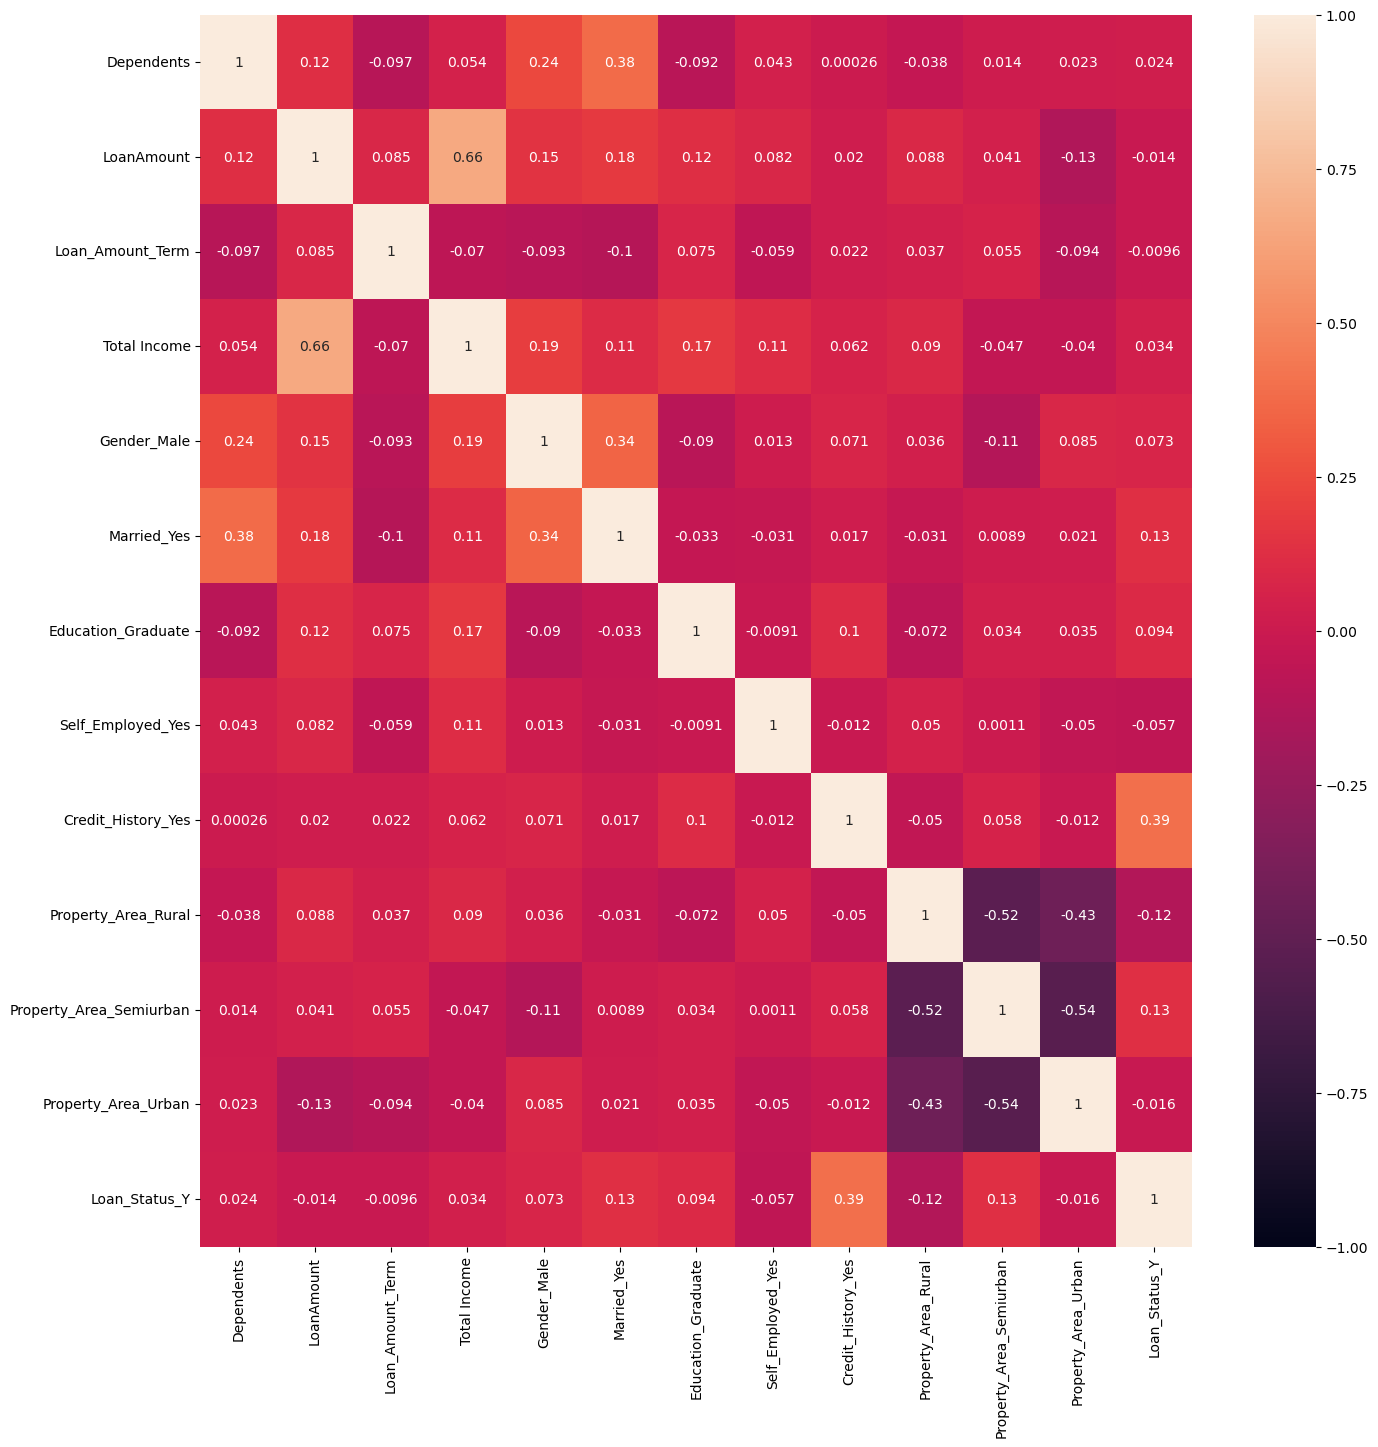

In [29]:
# Correlations matrix of the columns
plt.figure(figsize=(16,16))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1)
plt.show()

After hypothesis testing and examining the correlation matrix, there's just a little hope to achieve an accurate prediction of loan approval. We'll try it anyway, using a really powerful model: the random forest with grid search.

# Machine Learning Model

In [30]:
# Set y as independent variable - Loan_Status
y = df['Loan_Status_Y']

# Set X as the dependent variables - the rest of the columns
X = df.drop('Loan_Status_Y', axis = 1)

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [31]:
# Initialize Random Forest Model
rfc = RandomForestClassifier(random_state=42)

# Define parameter grid
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth' : [4,5,6,7,8,10],
    'criterion' :['gini', 'entropy']
}

# Grid search
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

# Best parameters
criterion = CV_rfc.best_params_["criterion"]
max_depth = CV_rfc.best_params_["max_depth"]
max_features = CV_rfc.best_params_["max_features"]
n_estimators = CV_rfc.best_params_["n_estimators"]

In [33]:
# Build model with best parameters
rfc1=RandomForestClassifier(random_state=42, max_features=max_features, n_estimators=n_estimators, max_depth=max_depth, criterion=criterion)
rfc1.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=7, max_features=None,
                       n_estimators=200, random_state=42)

In [34]:
# Make prediction on train set
y_train_pred = rfc1.predict(X_train)
print("Accuracy score: " + str(round(accuracy_score(y_train, y_train_pred), 4)))
print("Precision score: " + str(round(precision_score(y_train, y_train_pred), 4)))
print("Recall score: " + str(round(recall_score(y_train, y_train_pred), 4)))
print("F1 score: " + str(round(f1_score(y_train, y_train_pred), 4)))

Accuracy score: 0.9121
Precision score: 0.8915
Recall score: 1.0
F1 score: 0.9427


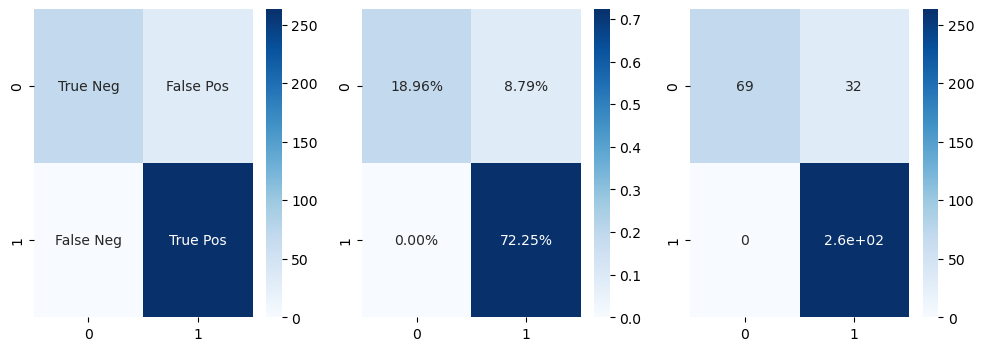

In [35]:
# Confusion matrix
cf_matrix = confusion_matrix(y_pred = y_train_pred, y_true = y_train)

fig, axes = plt.subplots(1, 3, figsize = (12,4))
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = True, cmap='Blues', ax = axes[2])
sns.heatmap(cf_matrix / np.sum(cf_matrix), annot = True, cmap='Blues', fmt='.2%', ax = axes[1])
sns.heatmap(cf_matrix, annot = labels, cmap='Blues', fmt = '', ax = axes[0])
plt.show()

It seems like a great model for train data! Only 8.79% of the data suffered from false prediction, more precisely 8.79% of the loan request was approved despite being declined according to the real data. I am afraid this model is overfit, I doubt we can get score this high from the test data.

Now let's use test data and see how well does the model performs!

In [36]:
# Now lets predict with the test data
y_test_pred = rfc1.predict(X_test)
print("Accuracy score: " + str(round(accuracy_score(y_test, y_test_pred), 4)))
print("Precision score: " + str(round(precision_score(y_test, y_test_pred), 4)))
print("Recall score: " + str(round(recall_score(y_test, y_test_pred), 4)))
print("F1 score: " + str(round(f1_score(y_test, y_test_pred), 4)))

Accuracy score: 0.75
Precision score: 0.7532
Recall score: 0.9355
F1 score: 0.8345


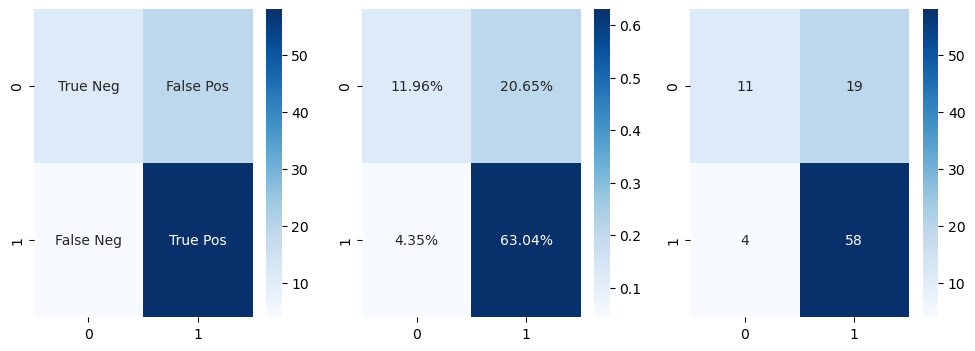

In [37]:
# Confusion matrix
cf_matrix = confusion_matrix(y_pred = y_test_pred, y_true = y_test)

fig, axes = plt.subplots(1, 3, figsize = (12,4))
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = True, cmap='Blues', ax = axes[2])
sns.heatmap(cf_matrix / np.sum(cf_matrix), annot = True, cmap='Blues', fmt='.2%', ax = axes[1])
sns.heatmap(cf_matrix, annot = labels, cmap='Blues', fmt = '', ax = axes[0])
plt.show()

Just as we thought, the scores declined for the test data due to train data overfit. The biggest problem is the number of false positives. For a loan prediction, such inaccuracy is not fortunate.

Let's take a look at the feature importance of the model!

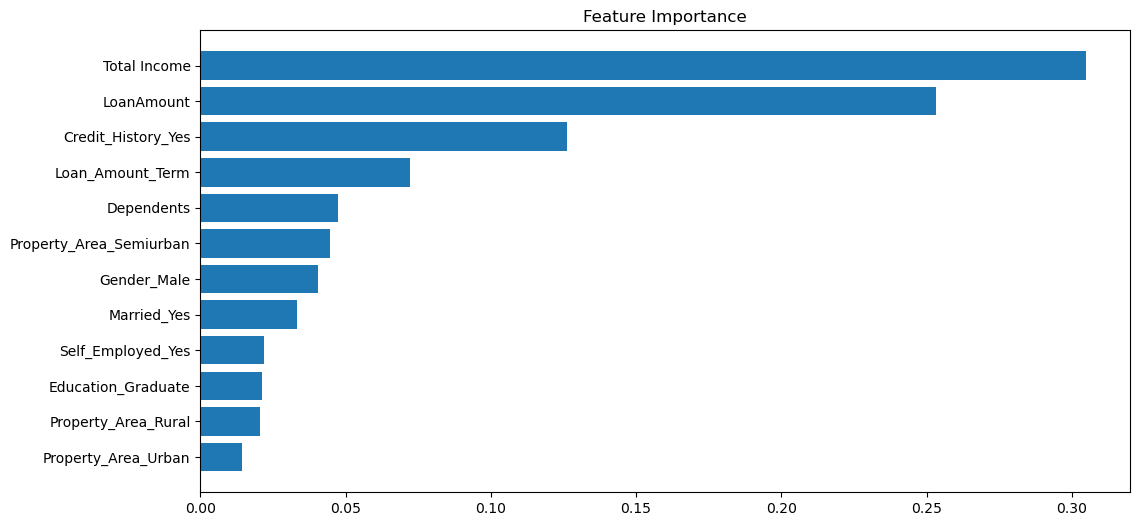

In [38]:
feature_importance = rfc1.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

# Conclusion

We have cleaned then conducted a very thorough analysis on Home Loan dataset. Examined how several variables relate to loan approval. Finally we build a machine learning model to predict loan approval. It has its shortcomings, but it is by no means inefficient.